<a href="https://colab.research.google.com/github/VGS18549/sentimentx/blob/main/SentimentX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

Created for Coursera guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/learn/tweet-emotion-tensorflow)

---

## Task 1: Introduction


## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [99]:
!pip install nlp

In [100]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.12.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [101]:
!pip install datasets

In [102]:
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion")

In [103]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [104]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [105]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = []
    for x in data:
      if x['label'] == 0:
        labels.append('sadness')
      elif x['label'] == 1:
        labels.append('joy')
      elif x['label'] == 2:
        labels.append('love')
      elif x['label'] == 3:
        labels.append('anger')
      elif x['label'] == 4:
        labels.append('fear')
      else:
        labels.append('surprise')

    return tweets, labels

In [106]:
tweets, labels = get_tweets(train)

In [107]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [108]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [109]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[0]]))

[[2, 139, 3, 679]]


## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

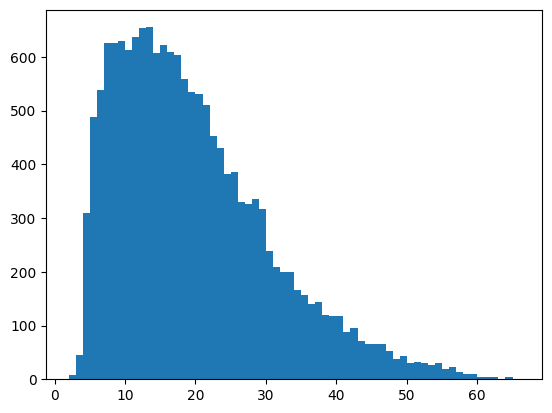

In [110]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [111]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [112]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [113]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [114]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [115]:
classes = set(labels)
print(classes)

{'surprise', 'sadness', 'joy', 'fear', 'anger', 'love'}


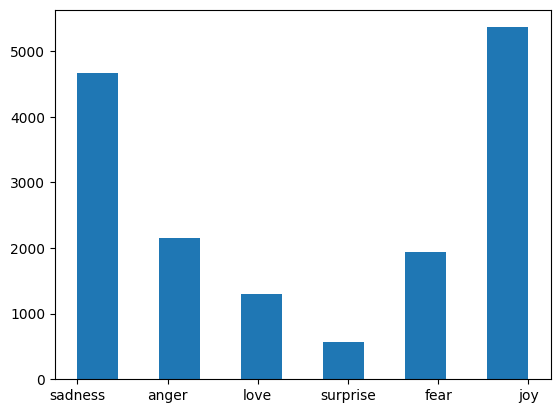

In [116]:
plt.hist(labels, bins=11)
plt.show()

In [117]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [118]:
classes_to_index

{'surprise': 0, 'sadness': 1, 'joy': 2, 'fear': 3, 'anger': 4, 'love': 5}

In [119]:
index_to_classes

{0: 'surprise', 1: 'sadness', 2: 'joy', 3: 'fear', 4: 'anger', 5: 'love'}

In [120]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [121]:
train_labels = names_to_ids(labels)
print(train_labels[0])

1


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [122]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [123]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [124]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 1)

In [125]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 50s 86ms/step - loss: 1.3541 - accuracy: 0.4231 - val_loss: 0.9425 - val_accuracy: 0.6365
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.6635 - accuracy: 0.7527 - val_loss: 0.6319 - val_accuracy: 0.7955
Epoch 3/20
500/500 [==============================] - 10s 19ms/step - loss: 0.3611 - accuracy: 0.8812 - val_loss: 0.5233 - val_accuracy: 0.8355
Epoch 4/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2397 - accuracy: 0.9264 - val_loss: 0.4514 - val_accuracy: 0.8615
Epoch 5/20
500/500 [==============================] - 10s 19ms/step - loss: 0.1827 - accuracy: 0.9464 - val_loss: 0.4540 - val_accuracy: 0.8595
Epoch 6/20
500/500 [==============================] - 10s 20ms/step - loss: 0.1363 - accuracy: 0.9597 - val_loss: 0.4199 - val_accuracy: 0.8730
Epoch 7/20
500/500 [==============================] - 17s 34ms/step - loss: 0.1139 - accuracy: 0.9651 - val_loss: 0.4259 - val_accuracy: 

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

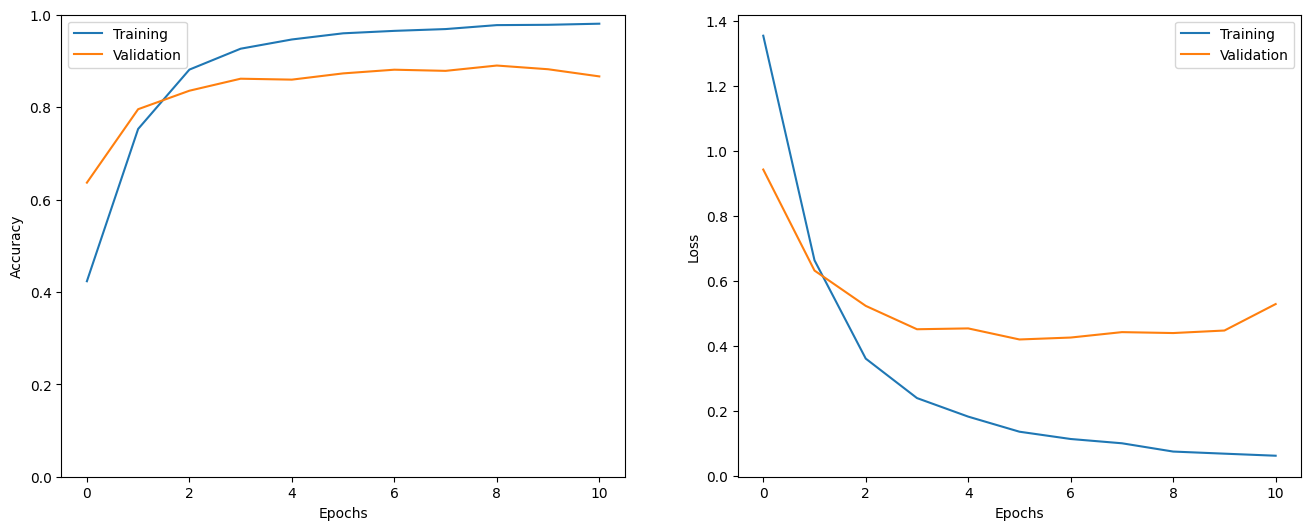

In [126]:
show_history(h)

In [127]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [128]:
_ = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 0s 8ms/step - loss: 0.4866 - accuracy: 0.8665


In [129]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_classes[test_labels[i]])

p = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]
pred_class = index_to_classes[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i roll my tongue over your labia sucking and nibbling drawing your flesh into my mouth and letting you feel the delicate pinch of my teeth
Emotion: love
1/1 [==============================] - 1s 1s/step
Predicted Emotion: love


In [130]:
preds = model.predict(test_sequences)

preds = np.argmax(preds,axis=-1)

63/63 [==============================] - 0s 6ms/step


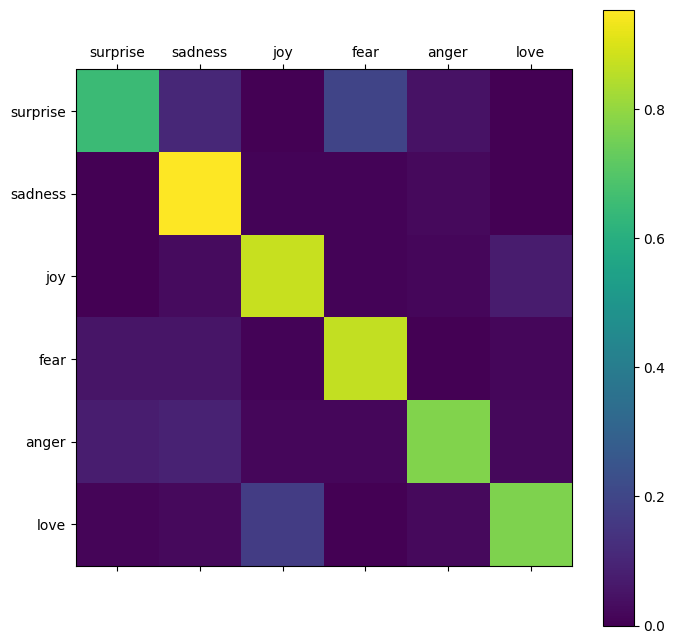

In [131]:
show_confusion_matrix(test_labels, preds, list(classes))